# $$Marketing~Analytics: ~Teste-A/B$$

## $$Conceito:$$

**Também conhecidos como testes divididos, permitem comparar duas versões de algo para saber qual é mais eficaz. Em poucas palavras, seus usuários gostam da versão A ou da versão B?**

**A principal motivação para fazer um teste A/B é a necessidade de melhora de alguma métrica**

## $$Premissas$$

**Criar 2 grupos: Controle e Tratamento:**

- **Controle:** É aquele cujas variáveis e taxas são a referência


- **Tratamento:**  É idêntico ao grupo controle, porém alterando uma variável


**Definir publico semelhante para o teste**


**Aleatoriedade dos grupos no teste**

__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__


__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

## $$Objetivo:$$  

## $$Páginas~ sem~Avaliações ~de~ Usuários ~Aumentam~ as~ Vendas ~de ~Produtos~Online ~ ?$$

## $$Analisar~ o~ resultado~ usando~ o~ Teste~ A/B$$

In [1]:
#Carregar os pacotes
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scipy
import warnings
warnings.filterwarnings('ignore')

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

# Base de Dados

In [2]:
# Carrega o dataset
dados = pd.read_csv("dados/dataset.csv")
dados

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28
...,...,...,...,...
54995,0x451451,A,False,2019-06-19
54996,0x871d51,A,False,2019-03-22
54997,0x50d163,A,False,2019-02-10
54998,0x3544c4,B,False,2020-01-09


**Dataset contém 55.000 mil registros e 4 variáveis.**

# Dicionário de Dados



## $$Variáveis:$$

**Id:** Código de identificação do usuário que entrou no site


**Variante:** 2 Grupos de controle: 

- **Variante A:** Mostra o número de comentários e avaliações de usuários.

- **Variante B:** Não mostra os comentários e as avaliações dos usuários no site. 


**Compra:** Se foi efetuado a compra(True) ou não(False) de um produto no site


**Data:** Data da visita do usuário no site 


# Análise Exploratória

In [3]:
# Verificar se existe valores nulos
dados.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [4]:
#Verificar se existe dados duplicados
sum(dados.duplicated())

0

In [5]:
# Tipos de variáveis
dados.dtypes

id          object
variante    object
compra        bool
data        object
dtype: object

**Note que para esse projeto não vai ser usado variável do tipo numérica**

In [6]:
# Verifica o total de valores únicos por coluna
dados.nunique()

id          55000
variante        2
compra          2
data          395
dtype: int64

**Para esse tipo de teste não podemos ter o mesmo usuário fazendo o teste mais de 1 vez, observe que a variavel 'id' não tem repetição do usuário**

In [7]:
# Data mínima
print(dados['data'].min())

# Data máxima
print(dados['data'].max())

2019-01-01
2020-01-30


**A data de coleta dos dados para o teste foi de aproximadamente 1 ano**

## Informações dos usuários

In [8]:
# Numero de amostras 
sum(dados.variante.value_counts())

55000

**55.000 mil usuários participaram do teste** 

In [9]:
#Resultado total das conversão 
conv = dados.compra.value_counts()

print('Resultado total das conversão:')
print(conv)


#Proporção total de compras não efetuadas
prop = round((dados[dados.compra == False].count()[0])/ sum(dados.variante.value_counts()),2)*100

print(f'\n\nProporção total de compras não efetuadas: {prop}%\n')

#Proporção total de compras efetuadas
c_efet = round((dados[dados.compra == True].count()[0])/ sum(dados.variante.value_counts()),2)*100

print(f'Proporção total de compras efetuadas: {c_efet}%\n')


Resultado total das conversão:
False    46416
True      8584
Name: compra, dtype: int64


Proporção total de compras não efetuadas: 84.0%

Proporção total de compras efetuadas: 16.0%



**Com os dados analisados podemos concluir que 84% dos usuários que entram no site não efetuam compras, independente se o site tiver avaliação dos produtos ou não, e 16% efetuam, isso é esperado para um site de e-commerce, pois muitos usuários entram para ver ou pesquisar o preço dos produtos**

## Informações da coluna Variante

In [10]:
# Numero de amostras coletadas por variante
total_ab = pd.DataFrame(dados.variante.value_counts())
total_ab['%'] = round(dados.variante.value_counts()/55000,2)
total_ab

,variante,%
A,50000,0.91
B,5000,0.09


**91% dos dados são da variante A, onde há avaliação dos produtos e 9% da variante B que não tem avaliação dos produtos, o tamanho da amostra pode ser um problema na hora de realizar o teste de hipótese, pois a variante B pode ser pequena para afirmar tal hipótese**

In [11]:
#Porcentagem das conversões para cada variante
tab_freq1 = dados.groupby(['variante', 'compra']).size().unstack(1)
tab_freq2 = pd.DataFrame(tab_freq1.iloc[0,:]/50000)
tab_freq2['B'] =tab_freq1.iloc[1,:]/5000
round(tab_freq2.T,2)

compra,False,True
A,0.85,0.15
B,0.80,0.20


**Note que a taxa de conversão da variante B é 5% maior quando comparado com a variante A, porém precisamos fazer o teste de hipótese para saber se estatisticamente essa porcentagem é significante ou não, pois como já mencionado o número de amostras são completamente desproporcionais entre as duas variantes**

## Pré-Processamento dos Dados



- Vamos dividir o experimento por meses, pois assim eliminamos o risco de ter discrepância nos dados em algum dos meses

In [12]:
# Função para extrair ano e mês da coluna data

def extrai_data(x):
    return x[:7] #Função extrai os primeiros 7 caracteres da coluna data

# Extrai ano e mês da coluna de data
dados['ano_mes'] = dados['data'].apply(extrai_data)
dados

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09
...,...,...,...,...,...
54995,0x451451,A,False,2019-06-19,2019-06
54996,0x871d51,A,False,2019-03-22,2019-03
54997,0x50d163,A,False,2019-02-10,2019-02
54998,0x3544c4,B,False,2020-01-09,2020-01


**Observe que a coluna 'ano_mes' foi agrupada por mês**

In [13]:
#Verificar todos os meses que foram feito os testes
dados.groupby(['ano_mes','variante'])['variante'].count()

ano_mes  variante
2019-01  A           3869
2019-02  A           3487
2019-03  A           3842
2019-04  A           3771
2019-05  A           3952
2019-06  A           3723
2019-07  A           3950
2019-08  A           3992
2019-09  A           3949
2019-10  A           3843
2019-11  A           3804
2019-12  A           3997
2020-01  A           3821
         B           5000
Name: variante, dtype: int64

**Note que apenas a data '2020-01' foi feito o teste A/B**

In [14]:
# Vamos filtrar apenas os dados de Janeiro/2020 
df_vendas_2020 = dados[dados['ano_mes'] == '2020-01']
df_vendas_2020

,id,variante,compra,data,ano_mes
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01
...,...,...,...,...,...
54974,0x8d888b,A,False,2020-01-27,2020-01
54982,0x28cefc,B,True,2020-01-03,2020-01
54987,0x2bbeed,B,False,2020-01-02,2020-01
54991,0x66e7ed,A,False,2020-01-22,2020-01


**Note que me janeiro de 2020 tivemos 8.821 amostras**

In [15]:
# Numero de amostras coletadas por variante
total01_ab = pd.DataFrame(df_vendas_2020.variante.value_counts(ascending=True))
total01_ab['Total'] = len(df_vendas_2020)
total01_ab['%_Amostral'] = df_vendas_2020.variante.value_counts()/8821
total01_ab

,variante,Total,%_Amostral
A,3821,8821,0.433171
B,5000,8821,0.566829


**Temos 8821 registros no total, sendo 57% dos dados da variante B e 43% da variante A**

### Criação do Baseline - Modelo com a performance mínima aceitável

Vamos criar um modelo base da taxa de conversão entre os grupos A e B antes de executar o teste de hipótese. Assim, saberemos a taxa de conversão base e o aumento desejado em compras que gostaríamos de testar.

* A será o grupo de controle 
* B será o grupo de teste


In [97]:
# Selecionamos apenas as variáveis significativas para o modelo
df_ab_data = df_vendas_2020[['variante', 'compra']]
df_ab_data

,variante,compra
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False
...,...,...
54974,A,False
54982,B,True
54987,B,False
54991,A,False


In [17]:
#Porcentagem das conversões para cada variante

# Tabela pivot para o sumário dos dados
df_ab_sumario = df_ab_data.pivot_table(values = 'compra', index = 'variante', aggfunc = np.sum)
df_ab_sumario

,compra
variante,
A,587
B,981


**Total de conversões dos grupos para o mês de janeiro**

In [18]:
# Sumário com taxa
df_ab_sumario['taxa'] = df_ab_data.pivot_table(values = 'compra', index = 'variante')
df_ab_sumario

,compra,taxa
variante,,
A,587,0.153625
B,981,0.196200


**Taxa de conversão dos grupos**

In [19]:
# Taxa de conversão da linha de base.
conversao_base = df_ab_sumario.iloc[0,1]
conversao_base

0.15362470557445695

**Para o teste A/B o grupo controle tem uma taxa de conversão de 15%, isso significa que se continuar do mesmo jeito 15% dos usuários que entrarem no site com avaliação, iram adquirir um produto, e a finalidade do teste é verificar se mudando para variante B onde os produtos não são avaliados consegue-se aumentar a taxa de conversão, para isso criamos o teste de hipótese**

In [20]:
# Efeito mínimo detectável
taxa_A = df_ab_sumario.iloc[0,1]
taxa_B = df_ab_sumario.iloc[1,1]

efeito_minimo = taxa_B - taxa_A
efeito_minimo

0.04257529442554306

**Diferença entre as taxas de conversão, podemos usar como nível de significância para o teste**

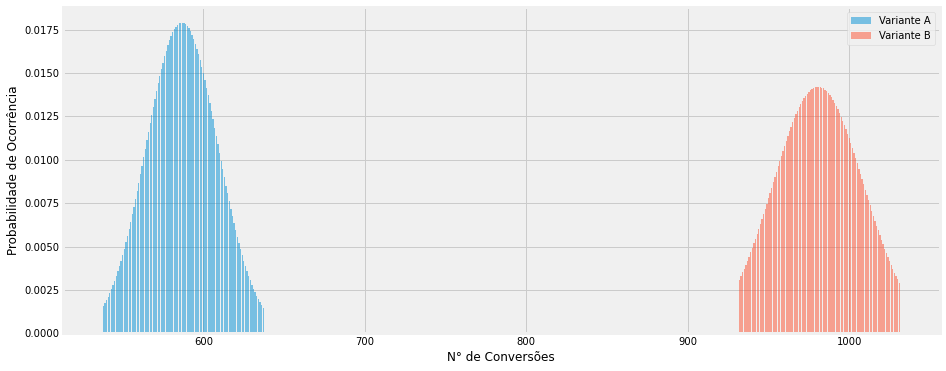

In [21]:
#Plot
conversao_A = df_ab_sumario.iloc[0,0]
conversao_B = df_ab_sumario.iloc[1,0]

total_A = total01_ab.iloc[0,0]
total_B = total01_ab.iloc[1,0]

# Plot da distribuição dos 2 grupos

# Área de plotagem 
fig, ax = plt.subplots(figsize = (14,6))

# Gráfico de A
xA = np.linspace(conversao_A - 49, conversao_A + 50, 100)
yA = scipy.binom(total_A, taxa_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B
xB = np.linspace(conversao_B - 49, conversao_B + 50, 100)
yB = scipy.binom(total_B, taxa_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)
ax.legend(['Variante A','Variante B'])
# Labels
plt.xlabel('N° de Conversões')
plt.ylabel('Probabilidade de Ocorrência');

**Note que a distribuição da variante A tem menor taxa de conversão, porém sua probabilidade de ocorrência é um pouco maior que a variante B, ainda assim não podemos afirmar que sites sem avaliações levam a uma maior conversão de compras em relação a sites que usam avaliações, pois a probabilidade de ocorrência da variante A é maior que a B, temos que igualar as 2 probabilidades para ter uma melhor conclusão do teste**

#  Teste de Hipóteses

## Configuração do experimento:

Nesta etapa você define qual será a hipótese testada no experimento:

- **H0: PB - PA = 0**, não há diferença estatística entre os dois grupos.


- **H1: PB - PA > 0**, há diferença estatística entre os dois grupos


Para fazer o teste, temos que levar em conta que as distribuições dos dados seguem uma distribuição normal e que as probabilidades de ocorrência sejam iguais para as 2 amostras

In [22]:
#Parametros para o teste

# Probabilidades (taxas de conversão)
p_A = taxa_A
p_B = taxa_B

# Número de conversões
N_A = 3821
N_B = 5000

print(f'Probabilidades (taxas de conversão):')
print(f'Variante A: {round(p_A,4)}')
print(f'Variante B: {p_B}')

print(f'\nNúmero de conversões:')
print(f'Variante A: {N_A}')
print(f'Variante B: {N_B}')

print('\nEfeito mínimo detectável')
print(f'{efeito_minimo}')

Probabilidades (taxas de conversão):
Variante A: 0.1536
Variante B: 0.1962

Número de conversões:
Variante A: 3821
Variante B: 5000

Efeito mínimo detectável
0.04257529442554306


**Parâmetros que serão usados para o teste de hipotese**

In [90]:
# Calculando a probabilidade agrupada
prob_agrupada = (p_A * N_A + p_B * N_B) / (N_A + N_B)


#OU 

#Total de vendas
t_vendas = np.sum(df_ab_sumario.compra)

#Total de usuarios 
tot_teste = len(df_vendas_2020)

# Calculando a probabilidade agrupada
prob_agrupada = t_vendas / tot_teste
prob_agrupada

0.17775762385217095

**Calculando a probabilidade agrupada, retiramos a probabilidade da variante A ser maior que a variante B, sendo assim podemos realizar o teste de Hipótese**

In [24]:
#Calcular o Alfa: Nível de confiança a 95%
alpha = (efeito_minimo) / (prob_agrupada * (1 - prob_agrupada) * (1 / N_A + 1 / N_B))**0.5
alpha

5.1827257006909795

**Valor de rejeição da variante B**

In [25]:
#Valor critico para um nivel de confiança de 95%
valor_critico = 1.64
print(f'Valor Critico: {valor_critico}')

Valor Critico: 1.64


In [26]:
# Verificamos se o alpha(região de rejeição) é maior que o valor critico(nível de confiança de 95%)

alpha > valor_critico

True

**O valor critico com um nível de confiança de 95% é menor que alpha, sendo assim podemos rejeitar H0, e concluir que para esse conjunto de dados se retirarmos as avaliações do site, há 95% de chance de aumentar o número de conversão de vendas dos produtos**  

# Teste A/B usando o algortimo MultiComparison

In [27]:
# Criando o teste
from statsmodels.stats.multicomp import MultiComparison

#Filtrando as vendas de janeiro
df_vendas_ = dados[dados['ano_mes'] == '2020-01']

#Criando o teste A/B
com = MultiComparison(df_vendas_['compra'],df_vendas_['variante'])

#Nivel de confiança a 95%
tukey = com.tukeyhsd(alpha=0.05)

#Sumario do teste
tukey.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
A,B,0.0426,0.001,0.0265,0.0587,True


**O algoritimo do teste A/B já leva em consideração o tamanho das amostras e calcula a diferença estatística das medias do teste e faz a comparação, caso H0 for rejeitado a coluna reject estará como True**

# Calcular o tamanho mínimo necessário das amostras para cada grupo

O cálculo determina o mínimo de amostras de cada variante necessária para ter um poder estatístico de 80% (probabilidade de ocorrência)

Nível de confiança de 95% para um teste A / B

$$ n_A = k*n_B $$

$$ n_B = (\frac{p_A(1-p_A)}{k}+p_B(1-p_B)) (\frac{Z_{1-\alpha} + Z_{1-\beta}}{p_A-p_B})^{2}$$

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_{1-\beta}+Z_{1-\alpha})^2}{(p_B-p_A)^2}$$

Abaixo está o código Python que executa o mesmo cálculo para o tamanho mínimo das amostras:

In [28]:
# Função para encontrar o tamanho mínimo da amostra
def calcula_tamanho_min_amostra(N_A, 
                                N_B, 
                                p_A, 
                                p_B, 
                                power = 0.8, 
                                sig_level = 0.05, 
                                two_sided = False):
   
    k = N_A/N_B
    
    # Distribuição normal para determinar os valores z
    standard_norm = scipy.norm(0, 1)

    # Encontramos o valor de z para o poder estatístico
    Z_beta = standard_norm.ppf(power)
    
    # Encontramos z alfa
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # Probabilidade agrupada
    pooled_prob = (p_A + p_B) / 2

    # Tamanho mínimo da amostra
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / efeito_minimo**2)    

    return min_N

In [29]:
# Calculamos o tamanho mínimo das amostras com two_sided = True
calcula_tamanho_min_amostra(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)

1249.8068972849476

**Para esse conjunto de dados onde temos 3821 registros para variante A e 5000 registros para variante B, com taxa de conversão de 15% para variante A e 20% para B, podemos afirmar que para um poder estatístico de 80% que é o mínimo aceitável, uma amostra de 1250 para cada variante ja é o suficiente para determinar o teste A/B**

# Conclusão:

**Para chegar à conclusão do teste A/B, há varios parâmetros a ser seguidos como vimos ao longo desse mini-projeto, o importante é chegar no resultado que seja confiável, por isso além do teste A/B é de extrema importância calcular o teste de hipotese, ele que vai nos dizer se o teste é confiável ou não através dos dados fornecidos**